In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from copy import deepcopy

In [2]:
# Import cell data
cells = pd.read_csv('data/cells_no_repeats.csv', index_col=0)
display(cells.head())

,cell_type,pt_root_id,pt_x,pt_y,pt_z
Unnamed: 0,,,,,
0,23P,864691135639004475,71136,110528,20220
1,23P,864691135771677771,72576,108656,20291
2,23P,864691135864089470,79632,121456,16754
3,23P,864691135560505569,80128,124000,16563
4,23P,864691136315868311,80144,126928,16622


In [3]:
# Import synapse data
synapse_data = pd.read_csv('data/synapses_w_ids.csv', index_col=0)
synapse_data.set_index('synapse_id', inplace=True)
synapse_data.head()

,pre_pt_root_id,post_pt_root_id,size,cell_type_pre,cb_x_pre,cb_y_pre,cb_z_pre,cell_type_post,cb_x_post,cb_y_post,cb_z_post,cb_x_diff,cb_y_diff,cb_z_diff,ctr_pt_x,ctr_pt_y,ctr_pt_z
synapse_id,,,,,,,,,,,,,,,,,
0,864691135564683351,864691136811959667,960,23P,557.248,570.560,732.52,23P,791.744,483.968,780.44,-234.496,86.592,-47.92,637.608,371.352,720.20
1,864691135614119115,864691135508912649,7576,23P,774.720,504.960,895.68,23P,807.936,459.584,870.28,-33.216,45.376,25.40,805.376,488.376,863.60
3,864691135113147801,864691136022555784,684,23P,883.072,451.456,817.84,23P,851.520,483.840,759.96,31.552,-32.384,57.88,858.328,516.648,775.88
4,864691135194393642,864691135341362885,23172,23P,781.248,449.984,696.88,23P,798.720,465.152,758.56,-17.472,-15.168,-61.68,789.400,478.040,691.00
5,864691136272938174,864691135683554546,3660,23P,762.368,473.792,773.68,23P,820.352,446.784,719.08,-57.984,27.008,54.60,756.624,440.928,710.60


In [233]:
# Slim it down to the xyz coordinates, keeping post-cell id for grouping later
all_synapses = synapse_data[['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z', 'post_pt_root_id', 'pre_pt_root_id', 'cell_type_pre', 'cell_type_post']]
display(all_synapses.head())

,ctr_pt_x,ctr_pt_y,ctr_pt_z,post_pt_root_id,pre_pt_root_id,cell_type_pre,cell_type_post
synapse_id,,,,,,,
0,637.608,371.352,720.20,864691136811959667,864691135564683351,23P,23P
1,805.376,488.376,863.60,864691135508912649,864691135614119115,23P,23P
3,858.328,516.648,775.88,864691136022555784,864691135113147801,23P,23P
4,789.400,478.040,691.00,864691135341362885,864691135194393642,23P,23P
5,756.624,440.928,710.60,864691135683554546,864691136272938174,23P,23P


In [234]:
synapses_by_cell = all_synapses.groupby('post_pt_root_id')
cell_id = 864691136811959667
test_group = synapses_by_cell.get_group(cell_id)
print(test_group.shape)
display(test_group.head())

(62, 7)


,ctr_pt_x,ctr_pt_y,ctr_pt_z,post_pt_root_id,pre_pt_root_id,cell_type_pre,cell_type_post
synapse_id,,,,,,,
0,637.608,371.352,720.20,864691136811959667,864691135564683351,23P,23P
375,803.444,500.728,754.36,864691136811959667,864691135841354467,23P,23P
749,751.392,572.320,746.76,864691136811959667,864691135478421446,4P,23P
922,882.160,356.384,741.64,864691136811959667,864691136811959667,23P,23P
1076,803.848,370.480,838.76,864691136811959667,864691135758828110,5P-IT,23P


In [220]:
def generate_msts(syn_by_cell, cells_df, k=6):
    """Generate a minimum spanning tree for each cell in the dataset.
    
    Parameters
    ----------
    syn_by_cell : pandas.core.groupby.generic.DataFrameGroupBy
        A grouped dataframe of synapse data, grouped by post-synaptic cell id.
        Includes columns for ctr_pt_x, ctr_pt_y, ctr_pt_z, post_pt_root_id, pre_pt_root_id, cell_type_pre, and cell_type_post.
    Returns
    -------
    msts : dict
        A dictionary of minimum spanning trees, with the cell id as the key.
        Each tree is a networkx.Graph object. The nodes are synapse ids, and the edge weights are the distances between synapses.
        Graph attributes:
            G.graph['cell_id'] : int
                The cell id of the post-synaptic cell the synapses belong to.
            G.graph['soma_pos'] : numpy.ndarray
                The xyz coordinates of the soma of the cell.
            G.graph['cell_type'] : str
                The cell type of the post-synaptic cell the synapses belong to.
        Node attributes:
            G.nodes[syn_id]['pos'] : numpy.ndarray
                The xyz coordinates of the synapse.
            G.nodes[syn_id]['cell_type'] : str
                The cell type of the pre-synaptic cell the synapse belongs to.
            G.nodes[syn_id]['pre_cell_id'] : int
                The cell id of the pre-synaptic cell the synapse belongs to.
    """
    msts = {}
    too_sparse = []
    for cell_id, syn_group in syn_by_cell:
        # If there are less than k synapses, skip this cell
        if syn_group.shape[0] < k:
            too_sparse.append(cell_id)
            continue

        # Keep relevant rows of synapse table
        synapses = syn_group[['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']]

        # Get the soma location for the cell
        cell_info = cells_df.loc[cells_df['pt_root_id'] == cell_id]
        soma_xyz = np.array(cell_info[['pt_x', 'pt_y', 'pt_z']].values[0])
        soma_xyz = np.matmul(soma_xyz, np.diag([4/1000, 4/1000, 40/1000]))

        # Add the soma location to the synapse table
        soma_df = pd.DataFrame(soma_xyz).T
        soma_df.columns = ['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']
        soma_df.index = [-1]
        synapses = pd.concat([synapses, soma_df])

        # Create a kdtree from the synapse locations
        kd_tree = NearestNeighbors(n_neighbors=k, algorithm='kd_tree').fit(synapses.values)
        distances, indices = kd_tree.kneighbors(synapses.values)

        # Create a graph from the synapse group
        nodes = synapses.index.values
        G = nx.Graph(cell_id=cell_id, soma_pos=soma_xyz, cell_type=syn_group.loc[nodes[-1], 'cell_type_post'])
        for node in nodes:
            G.add_node(node, pos=synapses.loc[node, ['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']].values,
                             cell_type=syn_group.loc[node, 'cell_type_pre'].values[0],
                             pre_cell_id=syn_group.loc[node, 'pre_pt_root_id'].values[0])

        # Add edges according to the kdtree
        for i in range(len(indices)):
            syn_id = nodes[i]
            for j in range(len(indices[i])):
                if i != indices[i][j]:
                    G.add_edge(syn_id, nodes[indices[i][j]], weight=distances[i][j])

        # Get the minimum spanning tree
        mst = nx.minimum_spanning_tree(G)
        # Add the graph to the dictionary
        msts[cell_id] = mst

        print(f'{cell_id}: {mst.number_of_nodes()} nodes, {mst.number_of_edges()} edges')

    return msts, too_sparse

In [221]:
msts, _ = generate_msts(deepcopy(synapses_by_cell), cells)

864691134884741370: 87 nodes, 86 edges
864691134884741626: 74 nodes, 73 edges
864691134884742138: 52 nodes, 51 edges
864691134884742906: 164 nodes, 162 edges
864691134884743162: 48 nodes, 47 edges
864691134884743418: 100 nodes, 99 edges
864691134884743930: 139 nodes, 138 edges
864691134884745210: 122 nodes, 120 edges
864691134884747002: 234 nodes, 232 edges
864691134884747514: 36 nodes, 35 edges
864691134884748026: 185 nodes, 184 edges
864691134884748282: 106 nodes, 104 edges
864691134884749562: 91 nodes, 90 edges
864691134884749818: 137 nodes, 136 edges
864691134884750074: 92 nodes, 91 edges
864691134884750842: 119 nodes, 118 edges
864691134884752122: 77 nodes, 76 edges
864691134884752890: 26 nodes, 25 edges
864691134884753146: 20 nodes, 19 edges
864691134884753402: 49 nodes, 48 edges
864691134884753658: 95 nodes, 94 edges
864691134884753914: 79 nodes, 78 edges
864691134884754170: 71 nodes, 70 edges
864691134884754426: 106 nodes, 104 edges
864691134884754682: 180 nodes, 179 edges
8646

In [223]:
print(len(msts))

55637


In [228]:
num_disconnected = 0
total = 0
soma_degrees = []
for mst in msts.values():
    if mst.number_of_edges() != mst.number_of_nodes() - 1:
        num_disconnected += 1
    total += 1
    soma_degrees.append(mst.degree[-1])

print(f'{num_disconnected} / {total} graphs are disconnected')
print(num_disconnected / total)

13204 / 55637 graphs are disconnected
0.2373240828944767


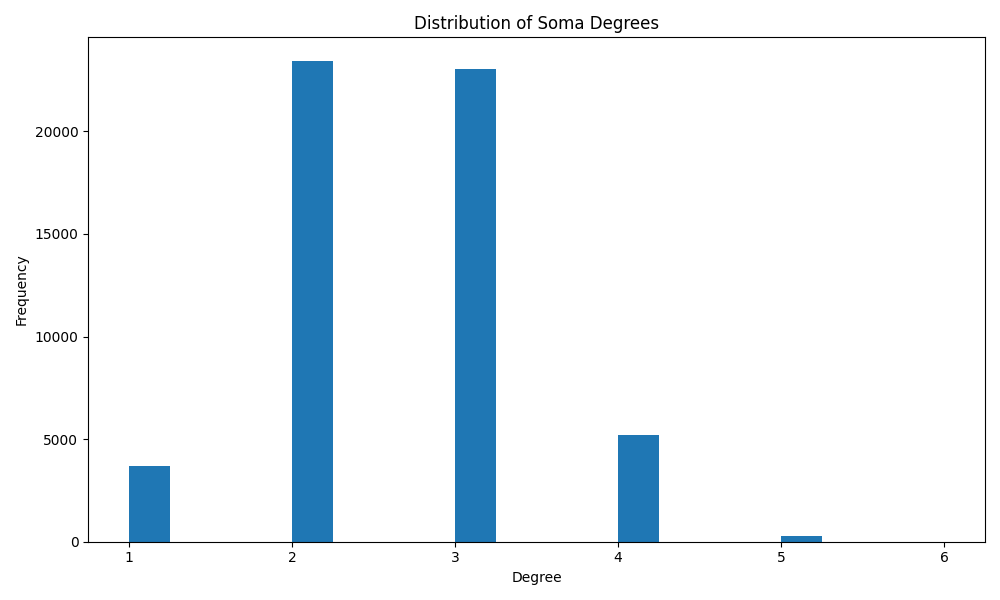

In [231]:
# Plot the distribution of soma degrees
plt.figure(figsize=(10, 6))
plt.hist(soma_degrees, bins=20)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Distribution of Soma Degrees')
plt.tight_layout()
plt.show()

In [182]:
cell_info = cells.loc[cells['pt_root_id'] == cell_id]
soma_xyz = np.array(cell_info[['pt_x', 'pt_y', 'pt_z']].values[0])
soma_xyz = np.matmul(soma_xyz, np.diag([4/1000, 4/1000, 40/1000]))
print(soma_xyz)

[791.744 483.968 780.44 ]


In [183]:
synapses_df = test_group[['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']]
synapses_df.loc[-1,:] = soma_xyz

synapses = np.array(synapses_df.values)
print(synapses.shape)

(63, 3)


/var/folders/00/x675wrkn78qd6yxs77mmkrh00000gn/T/ipykernel_93463/663402873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synapses_df.loc[-1,:] = soma_xyz


In [184]:
nodes = list(synapses_df.index.values.astype(int))
print(nodes)

G = nx.Graph(post_cell_id=cell_id)
G.add_nodes_from(nodes)
print(G.number_of_nodes())

[0, 375, 749, 922, 1076, 1161, 1512, 2405, 2547, 2673, 2884, 3769, 3911, 4405, 4511, 4949, 5856, 6850, 7314, 8428, 9437, 9763, 9845, 10603, 10700, 12610, 13377, 13556, 14089, 14114, 14808, 14985, 15033, 15444, 15729, 16722, 17127, 17394, 17429, 17435, 17837, 17974, 18142, 19451, 19938, 21110, 21305, 21532, 21708, 22204, 22330, 22427, 22493, 22767, 23086, 23263, 23315, 24123, 24156, 24820, 24862, 2829175, -1]
63


In [185]:
kd_tree = NearestNeighbors(n_neighbors=6, algorithm='kd_tree').fit(synapses)
distances, indices = kd_tree.kneighbors(synapses)
print(distances.shape)
print(indices[:10])
print(distances[:10])

(63, 6)
[[ 0 35 48 28 24 45]
 [ 1 53 61 62 25 29]
 [ 2 10 15 31 20 30]
 [ 3 60 46 43 14 40]
 [ 4 50 16 44  7 48]
 [ 5 23 18 39 42 27]
 [ 6 17  1 29 53 61]
 [ 7 44 50 16  4 47]
 [ 8 25 62 24 45 28]
 [ 9 61 28 62 24 51]]
[[  0.          58.63276899 147.91575105 171.97633177 174.92083741
  179.83588981]
 [  0.          11.67392513  18.64312291  33.13538894  36.29511592
   38.31786382]
 [  0.           7.07531144  32.75280116  32.8479038   52.75337108
   69.55393096]
 [  0.           1.90388235   2.89539496   2.91874219   3.4110409
    4.2511589 ]
 [  0.          16.1717304   42.28891108  54.82114862  78.86413025
   81.47884084]
 [  0.          36.75600936  42.54345844  48.17338352  53.54497175
   55.41338755]
 [  0.          34.25661746  38.64431135  47.88849933  48.81826347
   55.96516231]
 [  0.          30.77033064  74.15504147  74.32830309  78.86413025
   83.75584937]
 [  0.           6.7204238   11.29086002  21.43807827  28.22083089
   30.32705353]
 [  0.          31.90055047  33.277

In [186]:
for i in range(len(indices)):
    syn_id = nodes[i]
    for j in range(len(indices[i])):
        if i != indices[i][j]:
            G.add_edge(syn_id, nodes[indices[i][j]], weight=distances[i][j])

print(G.number_of_edges())

210


In [187]:
min_span_tree = nx.minimum_spanning_tree(G)
print(min_span_tree.number_of_edges())

62


In [188]:
pos = {}
for syn_id, row in test_group.iterrows():
    pos[syn_id] = (row['ctr_pt_z'], row['ctr_pt_y'])
pos[-1] = (soma_xyz[2], soma_xyz[1])

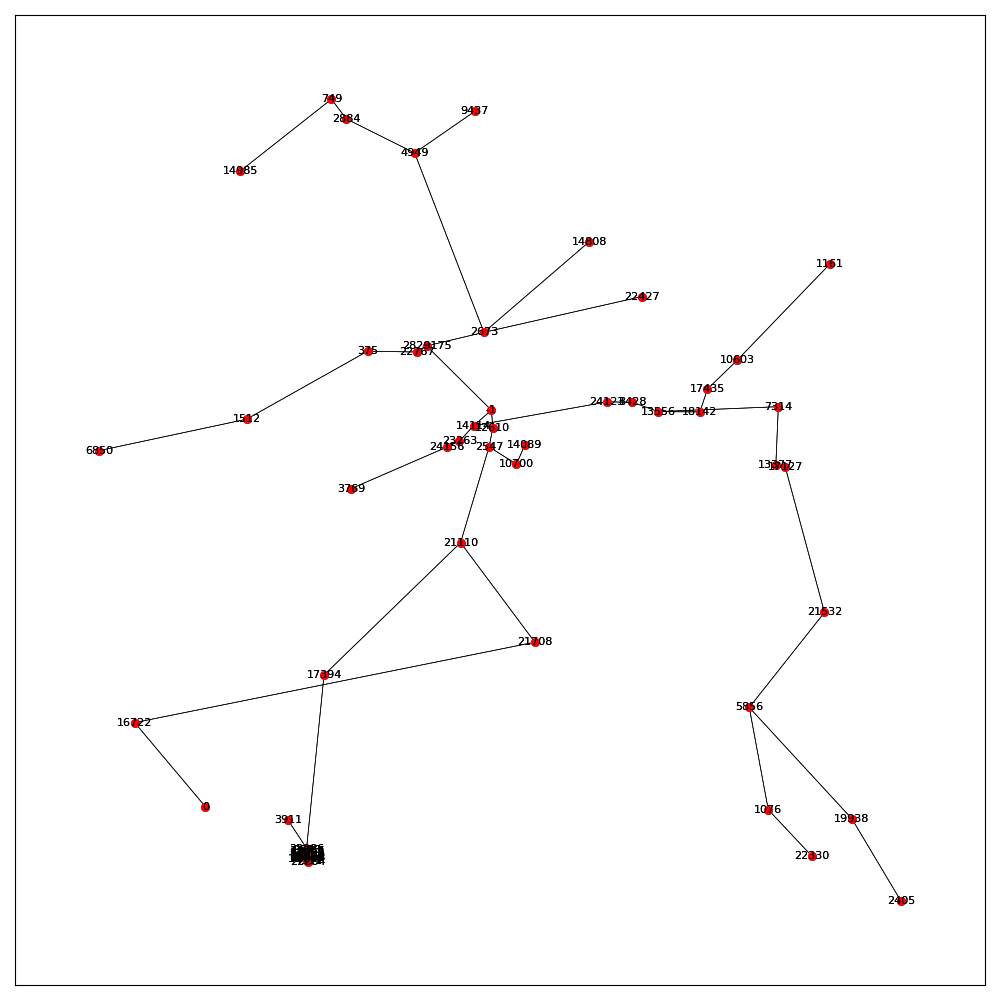

In [189]:
# Draw the minimum spanning tree
plt.figure(figsize=(10, 10))
nx.draw_networkx(min_span_tree, pos=pos, node_size=30, width=0.5, font_size=8)
nx.draw_networkx(mst, pos=pos, node_size=30, width=0.5, font_size=8, node_color='r')
plt.tight_layout()
plt.show()

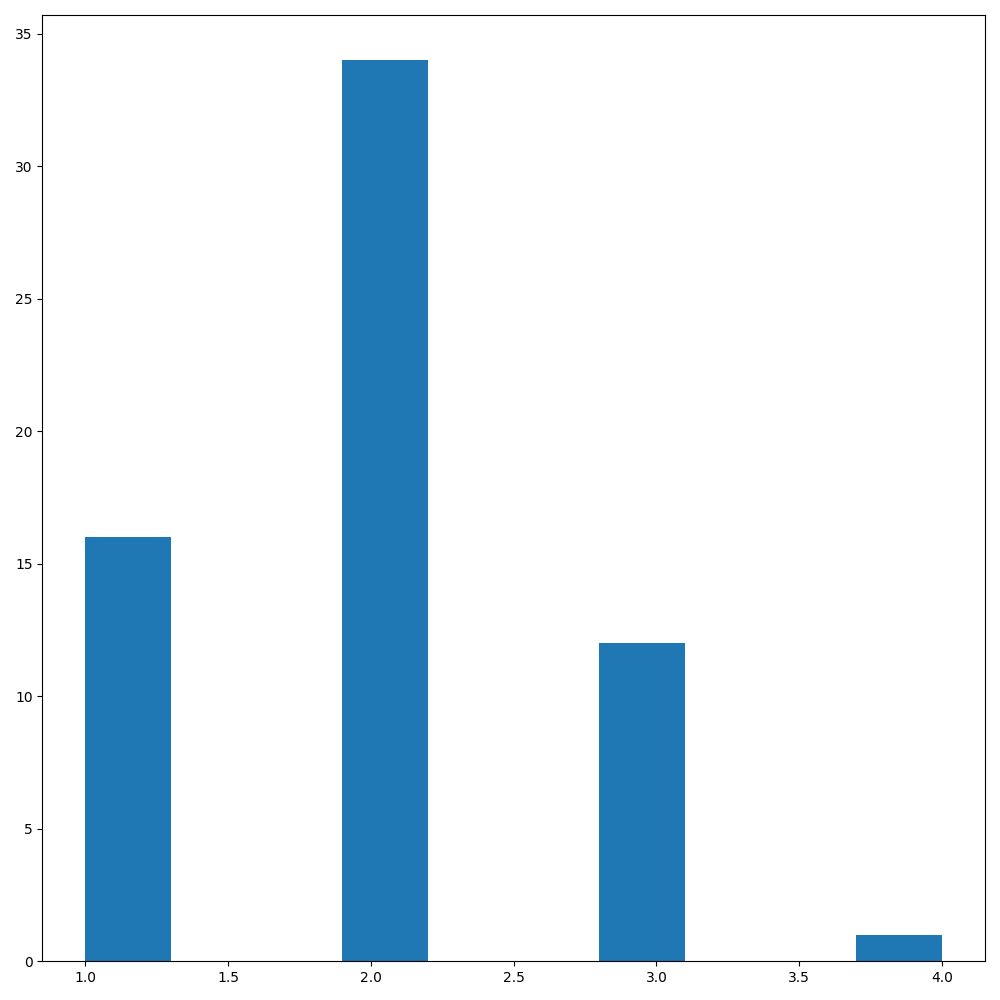

In [190]:
plt.figure(figsize=(10, 10))
plt.hist(dict(min_span_tree.degree()).values())
plt.tight_layout()
plt.show()

Saarthak Meeting Notes:

Iterate over connected components of the graph
- If has root (index -1), start there
- Else, start at any leaf

Store in dataframe and pad with NaNs

Longest common subsequence = similarity measure (lcss fast implementation library)

Filter for sequences >= length 3

Idea for disconnected component:
- Connect closest leaf to soma
- Preprocess graphs to ensure one connectd component

Similarity measure for finding repeats:
- The longest common subsequence needs to be at least 2/3 (some fraction) the length of the shorter one == match
        - If match, then repeat, if not, then not repeat

- Take the maximum of the similarity as measured by the fraction of the shorter sequence that the longest common subsequence is
- Record the distribution of the maximum pairwise similarities
- Do the same for the null model and aggregate results

Non-parametric test (parameter free)
Extremal value distributions
- Gumbel distributions

Immediate next steps:
1. Stich disconnected components to soma
2. Subtract soma radius from distance to nearest neighbors
3. Analyze corners and (in)validate dendrite as spanning tree

In [191]:
def traverse_branch(G, start_node, root_node):
    path = [root_node, start_node]
    node = start_node
    safeguard = root_node

    while G.degree(node) == 2:
        neighbors = np.array(list(G.neighbors(node)))
        next_node = neighbors[neighbors != path[-2]][0]

        safeguard = node
        node = next_node
        path.append(node)
    
    return path[1:], node, safeguard

# Given a graph and a root node, return a list of lists of nodes, where each list is a sequence of nodes such that each node is connected to the next node in the list and the last node in the list has degree > 2
def get_paths(G, root, entrance_node=None):
    paths = []
    
    root_neighbors = np.array(list(G.neighbors(root)))
    new_branches = root_neighbors[~np.isin(root_neighbors, entrance_node)]

    for node in new_branches:
        path, end_node, visited_node = traverse_branch(G, node, root)
        paths.append(path)

        if G.degree(end_node) > 2:
            paths.extend(get_paths(G, end_node, visited_node))
    
    return paths

def get_color_map(paths, root):
    colors = ['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#00ffff', '#ff00ff', '#ff8000', '#8000ff', '#00ff80', '#ff0080']
    color_map = {node: colors[i % len(colors)] for i, path in enumerate(paths) for node in path}
    color_map[root] = '#a0a0a0'
    return color_map

In [192]:
# Plot the synapes of the minimum spanning tree in 3D and connect them with lines according to the minimum spanning tree
def plot_mst_3d(G, synapses, root=-1, paths=None):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    if paths is None:
        paths = get_paths(G, root)
    
    color_map = get_color_map(paths, root)

    for node, row in synapses.iterrows():
        ax.scatter(row['ctr_pt_x'], row['ctr_pt_y'],row['ctr_pt_z'], c=color_map[node], s=10)
    
    # Connect the synapses with lines according to the edges of the minimum spanning tree
    soma_pos = G.graph['soma_pos']
    for edge in G.edges():
        node1, node2 = edge
        if node1 == root:
            ax.plot([soma_pos[0], synapses.loc[node2, 'ctr_pt_x']],
                    [soma_pos[1], synapses.loc[node2, 'ctr_pt_y']],
                    [soma_pos[2], synapses.loc[node2, 'ctr_pt_z']],
                    c='k')
        elif node2 == root:
            ax.plot([soma_pos[0], synapses.loc[node1, 'ctr_pt_x']],
                    [soma_pos[1], synapses.loc[node1, 'ctr_pt_y']],
                    [soma_pos[2], synapses.loc[node1, 'ctr_pt_z']],
                    c='k')
        else:
            ax.plot([synapses.loc[node1, 'ctr_pt_x'], synapses.loc[node2, 'ctr_pt_x']],
                    [synapses.loc[node1, 'ctr_pt_y'], synapses.loc[node2, 'ctr_pt_y']],
                    [synapses.loc[node1, 'ctr_pt_z'], synapses.loc[node2, 'ctr_pt_z']],
                    c='k')
    
    # Plot the soma
    ax.scatter(soma_pos[0], soma_pos[1], soma_pos[2], c='r', s=100)

    ax.set_xlabel('z')
    ax.set_ylabel('y')
    ax.set_zlabel('x')

    plt.tight_layout()
    plt.show()

    return paths

In [225]:
root = -1

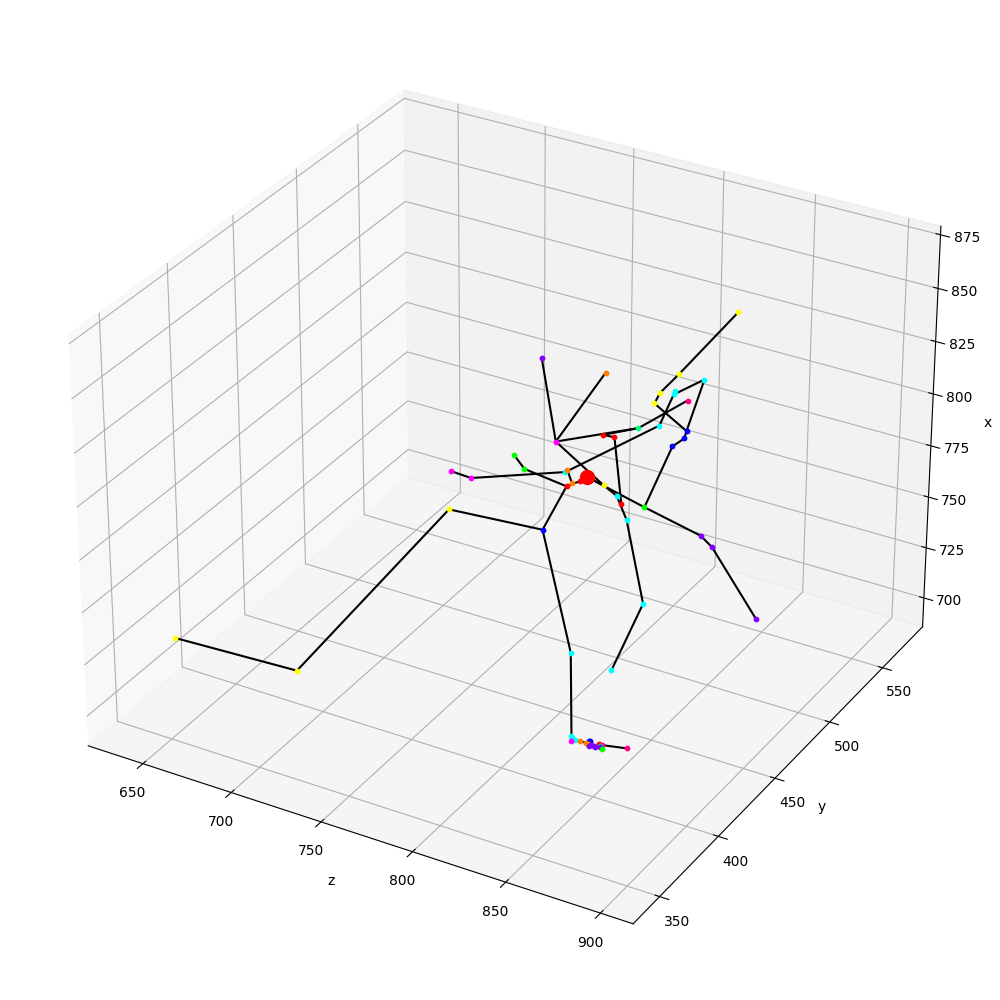

In [232]:
%matplotlib widget
paths = plot_mst_3d(min_span_tree, root, soma_xyz)
# paths_1 = plot_mst_3d(mst, root, soma_xyz)

In [195]:
print(paths)

[[12610, 2547], [10700, 14089], [21110], [21708, 16722, 0], [17394, 9845, 17974, 22493], [22204], [4405, 17429, 15033], [15444, 23315, 15729, 4511, 24862], [21305], [19451, 3911], [17837], [922], [24820, 9763, 23086], [2829175], [22767, 375, 1512, 6850], [2673], [22427], [14808], [4949], [9437], [2884, 749, 14985], [14114], [24123, 8428, 13556], [18142, 17435, 10603, 1161], [7314, 13377, 17127, 21532, 5856], [1076, 22330], [19938, 2405], [23263, 24156, 3769]]
